In [11]:
#Imports
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score

Data Defining

If tumor is M, will be classified as 1

Separated 70 / 30 the data, for further training / testing respectively

In [21]:
# Load the CSV file into a Pandas DataFrame
csv_file = './wdbc.data'
df = pd.read_csv(csv_file, delimiter=',')

# Print the column names to debug
print("Column names:", df.columns)

# Assuming df is your data frame and 'quality' is the column you want to predict
target = df.pop('diagnosis')
# Convert quality into binary classification (1 for quality >= 6, otherwise 0)
target = target.apply(lambda x: 1 if x >= 'M' else 0)

# Extract 30% of the data for validation
train_size = int(0.7 * len(df))
X_train, X_val = df[:train_size], df[train_size:]
y_train, y_val = target[:train_size], target[train_size:]


# Convert the DataFrame and the target column to TensorFlow tensors
y_train = tf.convert_to_tensor(y_train.values, dtype=tf.float32, name='y_train')
X_train = tf.convert_to_tensor(X_train.values, dtype=tf.float32, name='X_train')

y_val = tf.convert_to_tensor(y_val.values, dtype=tf.float32, name='y_val')
x_val = tf.convert_to_tensor(X_val.values, dtype=tf.float32, name='X_val')


y_train = tf.reshape(y_train, (-1, 1))
y_val = tf.reshape(y_val, (-1, 1))

print(X_train.shape)
print(y_train.shape)

Column names: Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave_points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')
(398, 31)
(398, 1)


In [3]:
# Define the logistic regression model
class LogisticRegressionModel(tf.Module):
    def __init__(self, input_dim):
        # Initialize weights and bias
        self.weights = tf.Variable(tf.random.normal([input_dim, 1]), dtype=tf.float32)
        self.bias = tf.Variable(tf.zeros([1]), dtype=tf.float32)

    def predict(self, X):
        logits = tf.matmul(X, self.weights) + self.bias
        return tf.sigmoid(logits)

    def loss_fn(self, X, y):
        predictions = self.predict(X)
        return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=predictions, labels=y))

    def compute_gradients(self, X, y):
        with tf.GradientTape() as tape:
            loss = self.loss_fn(X, y)
        gradients = tape.gradient(loss, [self.weights, self.bias])
        return gradients

In [4]:
# Define the training step
def train_step(model, X, y, learning_rate):
    gradients = model.compute_gradients(X, y)
    optimizer = tf.optimizers.SGD(learning_rate)
    optimizer.apply_gradients(zip(gradients, [model.weights, model.bias]))
    return model.loss_fn(X, y)

Epoch 0, Loss: 0.8741322159767151, Learning Rate: 0.001
Epoch 1000, Loss: 0.8587308526039124, Learning Rate: 0.001
Epoch 2000, Loss: 0.8415868282318115, Learning Rate: 0.001
Epoch 3000, Loss: 0.8227643370628357, Learning Rate: 0.001
Epoch 4000, Loss: 0.802646279335022, Learning Rate: 0.001
Epoch 5000, Loss: 0.7820379137992859, Learning Rate: 0.001
Epoch 6000, Loss: 0.7618675827980042, Learning Rate: 0.001
Epoch 7000, Loss: 0.7429718971252441, Learning Rate: 0.001
Epoch 8000, Loss: 0.7256097793579102, Learning Rate: 0.001
Epoch 9000, Loss: 0.7096467018127441, Learning Rate: 0.001
Epoch 0, Loss: 0.6154087781906128, Learning Rate: 0.01
Epoch 1000, Loss: 0.5838943719863892, Learning Rate: 0.01
Epoch 2000, Loss: 0.5727673172950745, Learning Rate: 0.01
Epoch 3000, Loss: 0.5670197606086731, Learning Rate: 0.01
Epoch 4000, Loss: 0.5632983446121216, Learning Rate: 0.01
Epoch 5000, Loss: 0.5606290102005005, Learning Rate: 0.01
Epoch 6000, Loss: 0.5585726499557495, Learning Rate: 0.01
Epoch 7000,

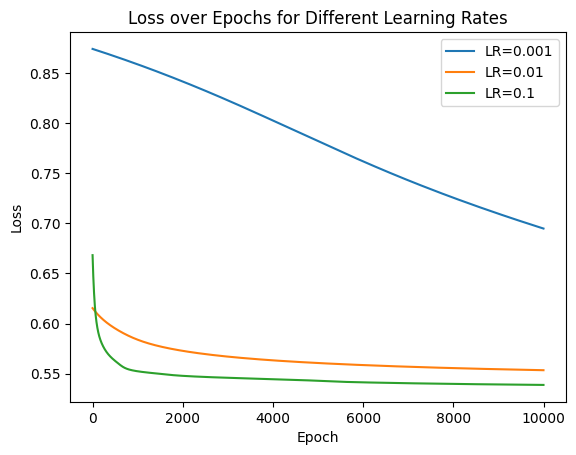

Best learning rate: 0.1 with final loss: 0.5387786626815796


In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Normalize the data
X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)

# Training the model with different learning rates
learning_rates = [0.001, 0.01, 0.1]
best_loss = float('inf')
best_lr = None
losses_dict = {}

for lr in learning_rates:
    model = LogisticRegressionModel(input_dim=X_train.shape[1])
    epochs = 10000
    losses = []
    
    for epoch in range(epochs):
        loss = train_step(model, X_train, y_train, learning_rate=lr)
        losses.append(loss.numpy())
        
        # Monitor gradients
        gradients = model.compute_gradients(X_train, y_train)
        
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Loss: {loss.numpy()}, Learning Rate: {lr}')
    
    losses_dict[lr] = losses
    if losses[-1] < best_loss:
        best_loss = losses[-1]
        best_lr = lr

# Plotting the loss values for different learning rates
for lr, losses in losses_dict.items():
    plt.plot(losses, label=f'LR={lr}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs for Different Learning Rates')
plt.legend()
plt.show()

print(f'Best learning rate: {best_lr} with final loss: {best_loss}')

In [20]:
# Testing the model

print(x_val.shape)
print(y_val.shape)

# Predict using the trained model (binary output)
y_test_pred = model.predict(x_val)


y_test_pred = tf.round(y_test_pred)  # Convert probabilities to binary outcomes (0 or 1)

# Convert tensors to numpy arrays for metric calculation
y_test_np = y_val.numpy()
y_test_pred_np = y_test_pred.numpy()

# Calculate accuracy, precision, and recall
accuracy = accuracy_score(y_test_np, y_test_pred_np)
precision = precision_score(y_test_np, y_test_pred_np)
recall = recall_score(y_test_np, y_test_pred_np)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

(171, 31)
(171, 1)
Accuracy: 0.7660818713450293
Precision: 0.0
Recall: 0.0
